In [1]:
from importlib import reload
import os
from time import time

import numpy as np
import scipy as sc
import pandas as pd
from sklearn.decomposition import PCA

import torch
print(torch.cuda.is_available())

import pprint
import editdistance

import utils
import tdre
import shifts
import viennarna_shifts as vshifts

import flexs
import flexs.utils.sequence_utils as s_utils

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

/homefs/home/wongfanc/miniconda3/envs/viennaenv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


False


2023-11-21 20:16:18.526455: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 20:16:18.709778: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-21 20:16:18.709809: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-11-21 20:16:20.512708: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# manually inspect length-50 RNA binding landscapes

In [67]:
# RNA binding landscape names: L[length]_RNA[1, 2, 3, 4 binding target][+ ]
reload(vshifts)
n_train = 1000
explorer_kwarg_name2vals = {'threshold': [0.3, 0.2, 0.1, 0.05]}
landscape_name = 'L50_RNA2'
seed_idx = 1

model_class = flexs.baselines.models.LinearRegression
explorer_class = flexs.baselines.explorers.Adalead
flexsshift = vshifts.FLEXSShift(landscape_name)
trainseqs_n, ytrain_n, predtrain_n, calseqs_n, ycal_n, testseqs_list = flexsshift.get_data(
    n_train,
    model_class,
    explorer_class,
    explorer_kwarg_name2vals,
    seed_idx=seed_idx,
    avg_n_mut=2,
    save_fname_prefix=None
)
predcal_n =  flexsshift.explorer.model.get_fitness(calseqs_n)
yseed = flexsshift.landscape.get_fitness([flexsshift.explorer.starting_sequence])[0]

Normalizing by sequence length 50


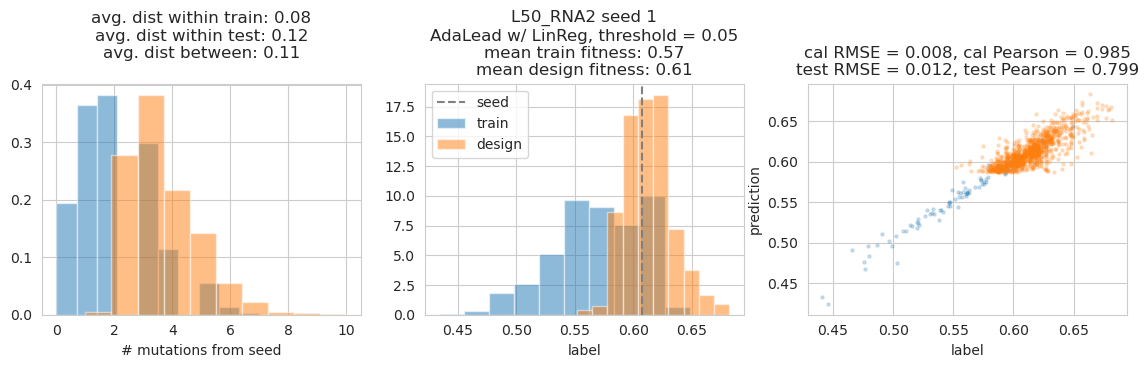

In [72]:
threshold = 0.05
thresh_idx = explorer_kwarg_name2vals['threshold'].index(threshold)
testseqs_n, ytest_n, predtest_n = testseqs_list[thresh_idx]

# mutations away from seed in training and test sequencess
nmuttrain_n = np.array([editdistance.eval(flexsshift.problem['starts'][seed_idx], s) for s in trainseqs_n])
nmuttest_n = np.array([editdistance.eval(flexsshift.problem['starts'][seed_idx], s) for s in testseqs_n])
disttrain, disttest, distbetween = utils.pairwise_distances(trainseqs_n, testseqs_n, n_pairs=10000)

plt.figure(figsize=(14, 3));
plt.subplot(131)
plt.hist(nmuttrain_n, density=True, alpha=0.5);
plt.hist(nmuttest_n, density=True, alpha=0.5);
plt.xlabel('# mutations from seed');
plt.title('avg. dist within train: {:.2f}\navg. dist within test: {:.2f}\navg. dist between: {:.2f}\n'.format(
    np.mean(disttrain), np.mean(disttest), np.mean(distbetween)
))

plt.subplot(132)
plt.hist(ytrain_n, alpha=0.5, density=True);
plt.hist(ytest_n, alpha=0.5, density=True);
plt.axvline(yseed, linestyle='--', color='gray')
plt.title('{} seed {}\nAdaLead w/ LinReg, threshold = {}\nmean train fitness: {:.2}\nmean design fitness: {:.2f}'.format(
    landscape_name, seed_idx, threshold, np.mean(ytrain_n), np.mean(ytest_n)
))
plt.legend(['seed', 'train', 'design', ]);
plt.xlabel('label');

plt.subplot(133)
calrmse = np.sqrt(np.mean(np.square(ycal_n - predcal_n)))
calr, _ = sc.stats.pearsonr(ycal_n, predcal_n)
testrmse = np.sqrt(np.mean(np.square(ytest_n - predtest_n)))
testr, _ = sc.stats.pearsonr(ytest_n, predtest_n)
plt.scatter(ycal_n, predcal_n, alpha=0.2, s=5);
plt.scatter(ytest_n, predtest_n, alpha=0.2, s=5);
plt.xlabel('label');
plt.ylabel('prediction');
plt.title('cal RMSE = {:.3f}, cal Pearson = {:.3f}\ntest RMSE = {:.3f}, test Pearson = {:.3f}'.format(
    calrmse, calr, testrmse, testr
));

In [2]:
reload(vshifts)
save_fname_dir = '110923'
ns = [20]
explorer_kwarg_name2vals = {'threshold': [0.3, 0.2, 0.1, 0.05]}
model_class = flexs.baselines.models.LinearRegression
explorer_class = flexs.baselines.explorers.Adalead

vshifts.generate_rna_data(
    model_class, explorer_class, explorer_kwarg_name2vals, save_fname_dir, ns=ns
)

Generating data from the following landscapes:
['L50_RNA1', 'L50_RNA2', 'L50_RNA3', 'L50_RNA4']
with the following amounts of training data:
[20]
Saved training, calibration, and design data to /data/wongfanc/dre-data/data/110923/L50_RNA1-seed1-n20-threshold0.3.npz
Saved training, calibration, and design data to /data/wongfanc/dre-data/data/110923/L50_RNA1-seed1-n20-threshold0.2.npz
Saved training, calibration, and design data to /data/wongfanc/dre-data/data/110923/L50_RNA1-seed1-n20-threshold0.1.npz
Saved training, calibration, and design data to /data/wongfanc/dre-data/data/110923/L50_RNA1-seed1-n20-threshold0.05.npz
Generated and saved data for L50_RNA1, n = 20, seed 1 (1 s).
Saved training, calibration, and design data to /data/wongfanc/dre-data/data/110923/L50_RNA1-seed2-n20-threshold0.3.npz
Saved training, calibration, and design data to /data/wongfanc/dre-data/data/110923/L50_RNA1-seed2-n20-threshold0.2.npz
Saved training, calibration, and design data to /data/wongfanc/dre-data/

Saved training, calibration, and design data to /data/wongfanc/dre-data/data/110923/L50_RNA4-seed1-n20-threshold0.3.npz
Saved training, calibration, and design data to /data/wongfanc/dre-data/data/110923/L50_RNA4-seed1-n20-threshold0.2.npz
Saved training, calibration, and design data to /data/wongfanc/dre-data/data/110923/L50_RNA4-seed1-n20-threshold0.1.npz
Saved training, calibration, and design data to /data/wongfanc/dre-data/data/110923/L50_RNA4-seed1-n20-threshold0.05.npz
Generated and saved data for L50_RNA4, n = 20, seed 1 (1 s).
Saved training, calibration, and design data to /data/wongfanc/dre-data/data/110923/L50_RNA4-seed2-n20-threshold0.3.npz
Saved training, calibration, and design data to /data/wongfanc/dre-data/data/110923/L50_RNA4-seed2-n20-threshold0.2.npz
Saved training, calibration, and design data to /data/wongfanc/dre-data/data/110923/L50_RNA4-seed2-n20-threshold0.1.npz
Saved training, calibration, and design data to /data/wongfanc/dre-data/data/110923/L50_RNA4-seed2

# try TDRE on length-14 RNA binding landscapes

In [2]:
# TODO: install/move FLEXS
reload(vshifts)
n_train = 10000
explorer_kwarg_name2vals = {'threshold': [0.3, 0.2, 0.1]}
landscape_name = 'L14_RNA1'
save_fname_prefix = '{}-linreg-adalead'.format(landscape_name)

model_class = flexs.baselines.models.LinearRegression
explorer_class = flexs.baselines.explorers.Adalead
flexsshift = vshifts.FLEXSShift(landscape_name)
trainseqs_n, ytrain_n, calseqs_n, ycal_n, testseqs_list = flexsshift.get_data(
    n_train,
    model_class,
    explorer_class,
    explorer_kwarg_name2vals,
    seed_idx=1,
    avg_n_mut=2,
    save_fname_prefix=save_fname_prefix
)
print(ytrain_n.size, ycal_n.size)

Saved training, calibration, and design data to L14_RNA1-linreg-adalead-threshold0.3.npz
Saved training, calibration, and design data to L14_RNA1-linreg-adalead-threshold0.2.npz
Saved training, calibration, and design data to L14_RNA1-linreg-adalead-threshold0.1.npz
10000 1000


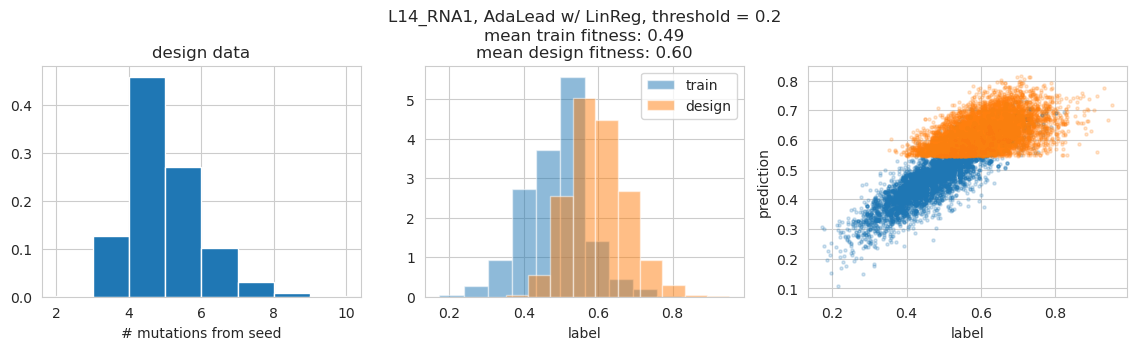

In [21]:
thresh = 0.2  # plot to see individual thresholds
thresh_idx = 1
testseqs_n, ytest_n, predtest_n = testseqs_list[thresh_idx]
nmut_n = np.array([editdistance.eval(flexsshift.problem['starts'][1], s) for s in testseqs_n])
predtrain_n =  flexsshift.explorer.model.get_fitness(trainseqs_n)

plt.figure(figsize=(14, 3));
plt.subplot(131)
plt.hist(nmut_n, density=True, bins=8);
plt.xlabel('# mutations from seed');
plt.title('design data');

plt.subplot(132)
plt.hist(ytrain_n, alpha=0.5, density=True);
plt.hist(ytest_n, alpha=0.5, density=True);
plt.title('{}, AdaLead w/ LinReg, threshold = {}\nmean train fitness: {:.2}\nmean design fitness: {:.2f}'.format(
    landscape_name, thresh, np.mean(ytrain_n), np.mean(ytest_n)
))
plt.legend(['train', 'design']);
plt.xlabel('label');

plt.subplot(133)
plt.scatter(ytrain_n, predtrain_n, alpha=0.2, s=5);
plt.scatter(ytest_n, predtest_n, alpha=0.2, s=5);
plt.xlabel('label');
plt.ylabel('prediction');

In [2]:
# try single bridge for one threshold
landscape_name = 'L14_RNA1'
save_fname_prefix = '{}-linreg-adalead'.format(landscape_name)
threshold = 0.3

dload = np.load('{}-threshold{}.npz'.format(save_fname_prefix, threshold))
trainseqs_n = dload['trainseqs_n']
ytrain_n = dload['ytrain_n']
calseqs_n = dload['calseqs_n']
ycal_n = dload['ycal_n']
testseqs_n = dload['testseqs_n']
ytest_n = dload['ytest_n']
predtest_n = dload['predtest_n']
print(ytrain_n.size, ycal_n.size, ytest_n.size)

d = 14 * 4
m = 1
n_hidden = 16
device = torch.device('cuda')
dtype = torch.float
config = {
    'waymark_type': 'mixed_dimensions',
    'val_frac': 0.1,
    'n_steps': 5000,
    'lr': 1e-3,
}

Xcal_nxd = np.array([s_utils.string_to_one_hot(seq, s_utils.RNAA).flatten() for seq in calseqs_n])
Xm_nxd = np.array([s_utils.string_to_one_hot(seq, s_utils.RNAA).flatten() for seq in trainseqs_n])
X0_nxd = np.array([s_utils.string_to_one_hot(seq, s_utils.RNAA).flatten() for seq in testseqs_n])

model = tdre.UnsharedTelescopingLogDensityRatioEstimator(
#     lambda x: tdre.FeedForward(x, n_hidden=n_hidden), d, n_ratio=m,
    tdre.Quadratic, d, n_ratio=m,
    device=device, dtype=dtype
)

train_dfs = model.fit(X0_nxd, Xm_nxd, config)
classical = model.forecast_meany(Xcal_nxd, ycal_n, use_logsumexp=True)
imputed = np.mean(predtest_n)
truemean = np.mean(ytest_n)
print(truemean, classical, imputed)

10000 1000 10000
Generated 1 waymarks.


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:10<00:00, 462.08it/s]

Done fitting bridge 1 / 1 (12 s).
0.5728626218906478 0.5014913365170242 0.58811181640625


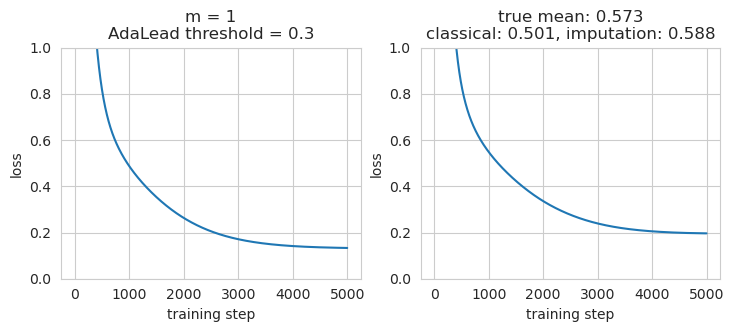

In [3]:
m_to_plot = 1

plt.figure(figsize=(8.5, 3))
plt.subplot(121)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['train_loss']);
plt.xlabel('training step');
plt.ylabel('loss');
plt.title('m = {}\nAdaLead threshold = {}'.format(m, threshold));
plt.ylim([0, 1]);

plt.subplot(122)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['val_loss']);
plt.xlabel('training step');
plt.ylabel('loss');
plt.title('true mean: {:.3f}\nclassical: {:.3f}, imputation: {:.3f}'.format(
    truemean, classical, imputed
));
plt.ylim([0, 1]);

In [ ]:
# load up different thresholds as waymarks 
reload(tdre)
landscape_name = 'L14_RNA1'
save_fname_prefix = '{}-linreg-adalead'.format(landscape_name)
thresholds = [0.3]
m = len(thresholds) + 1

dload = np.load('{}-threshold0.1.npz'.format(save_fname_prefix))
testseqs_n = dload['testseqs_n']
ytest_n = dload['ytest_n']
print(np.mean(ytest_n))
X0_nxd = np.array([s_utils.string_to_one_hot(seq, s_utils.RNAA).flatten() for seq in testseqs_n])
X_m1xnxd = np.zeros([m + 1, X0_nxd.shape[0], X0_nxd.shape[1]])
X_m1xnxd[0] = X0_nxd
for i in range(m + 1):
    print(np.linalg.norm(X_m1xnxd[i]))

for t, threshold in enumerate(thresholds):
    dload = np.load('{}-threshold{}.npz'.format(save_fname_prefix, threshold))
    testseqs_n = dload['testseqs_n']
    ytest_n = dload['ytest_n']
    print(np.mean(ytest_n))
    predtest_n = dload['predtest_n']
    Xk_nxd = np.array([s_utils.string_to_one_hot(seq, s_utils.RNAA).flatten() for seq in testseqs_n])
    X_m1xnxd[t + 1] = Xk_nxd
    for i in range(m + 1):
        print(np.linalg.norm(X_m1xnxd[i]))
    
dload = np.load('{}-threshold0.3.npz'.format(save_fname_prefix))
trainseqs_n = dload['trainseqs_n']
ytrain_n = dload['ytrain_n']

print(np.mean(ytrain_n))
Xm_nxd = np.array([s_utils.string_to_one_hot(seq, s_utils.RNAA).flatten() for seq in trainseqs_n])
X_m1xnxd[-1] = Xm_nxd
for i in range(m + 1):
    print(np.linalg.norm(X_m1xnxd[i]))

In [ ]:
# provide waymarks X_m1xnxd from different thresholds
d = 14 * 4
m = X_m1xnxd.shape[0] - 1
n_hidden = 16
device = torch.device('cuda')
dtype = torch.float
config = {
    'waymark_type': 'mixed_dimensions',
    'val_frac': 0.1,
    'n_steps': 5000,
    'lr': 1e-3,
}

model = tdre.UnsharedTelescopingLogDensityRatioEstimator(
#     lambda x: tdre.FeedForward(x, n_hidden=n_hidden), d, n_ratio=m,
    tdre.Quadratic, d, n_ratio=m,
    device=device, dtype=dtype
)

train_dfs = model.fit(config, X_m1xnxd=X_m1xnxd)
classical = model.forecast_meany(Xm_nxd, ytrain_n, use_logsumexp=True)



dload = np.load('{}-threshold0.1.npz'.format(save_fname_prefix))
ytest_n = dload['ytest_n']
predtest_n = dload['predtest_n']

imputed = np.mean(predtest_n)
truemean = np.mean(ytest_n)
print(truemean, classical, imputed)

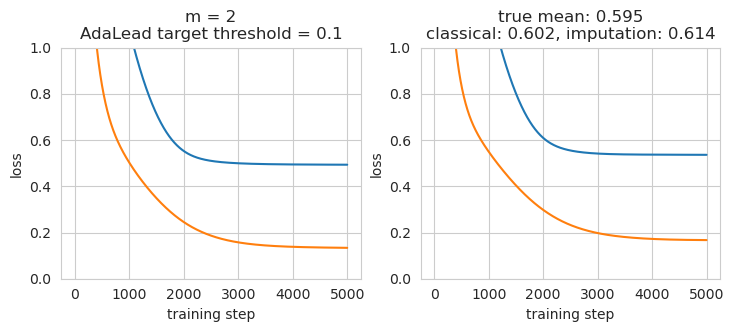

In [11]:
m_to_plot = 2

plt.figure(figsize=(8.5, 3))
plt.subplot(121)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['train_loss']);
plt.xlabel('training step');
plt.ylabel('loss'); 
plt.title('m = {}\nAdaLead target threshold = {}'.format(m, 0.1));
plt.ylim([0, 1]);

plt.subplot(122)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['val_loss']);
plt.xlabel('training step');
plt.ylabel('loss');
plt.title('true mean: {:.3f}\nclassical: {:.3f}, imputation: {:.3f}'.format(
    truemean, classical, imputed
));
plt.ylim([0, 1]);

In [14]:
# compare to single bridge
d = 14 * 4
m = 1
n_hidden = 16
device = torch.device('cuda')
dtype = torch.float
config = {
    'waymark_type': 'mixed_dimensions',
    'val_frac': 0.1,
    'n_steps': 5000,
    'lr': 1e-3,
}

dload = np.load('{}-threshold0.1.npz'.format(save_fname_prefix))
trainseqs_n = dload['trainseqs_n']
ytrain_n = dload['ytrain_n']
print(np.mean(ytrain_n))
testseqs_n = dload['testseqs_n']
ytest_n = dload['ytest_n']
predtest_n = dload['predtest_n']
print(np.mean(ytest_n))
X0_nxd = np.array([s_utils.string_to_one_hot(seq, s_utils.RNAA).flatten() for seq in testseqs_n])
Xm_nxd = np.array([s_utils.string_to_one_hot(seq, s_utils.RNAA).flatten() for seq in trainseqs_n])

model = tdre.UnsharedTelescopingLogDensityRatioEstimator(
#     lambda x: tdre.FeedForward(x, n_hidden=n_hidden), d, n_ratio=m,
    tdre.Quadratic, d, n_ratio=m,
    device=device, dtype=dtype
)

train_dfs = model.fit(config, X0_nxp=X0_nxd, Xm_nxp=Xm_nxd)
classical = model.forecast_meany(Xm_nxd, ytrain_n, use_logsumexp=True)
imputed = np.mean(predtest_n)
truemean = np.mean(ytest_n)
print(truemean, classical, imputed)

0.49246304820757086
0.5952103449599836
Generating waymarks.
Generated 1 waymarks.


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:10<00:00, 458.83it/s]

Done fitting bridge 1 / 1 (10 s).
0.5952103449599836 0.5590050446433312 0.61435244140625


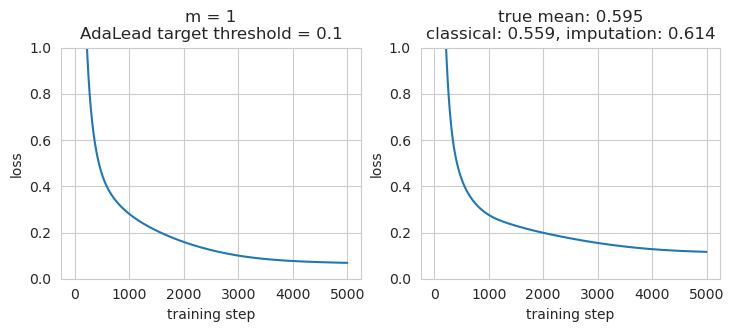

In [16]:
m_to_plot = 1

plt.figure(figsize=(8.5, 3))
plt.subplot(121)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['train_loss']);
plt.xlabel('training step');
plt.ylabel('loss'); 
plt.title('m = {}\nAdaLead target threshold = {}'.format(m, 0.1));
plt.ylim([0, 1]);

plt.subplot(122)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['val_loss']);
plt.xlabel('training step');
plt.ylabel('loss');
plt.title('true mean: {:.3f}\nclassical: {:.3f}, imputation: {:.3f}'.format(
    truemean, classical, imputed
));
plt.ylim([0, 1]);

# try unshared bridges on length-50 RNA binding landscapes

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05, 0.1, 0.2, 0.3]


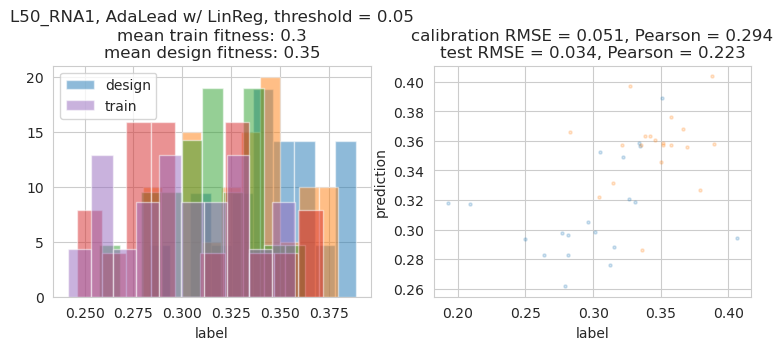

In [2]:
reload(vshifts)
landscape_name = 'L50_RNA1'
seed_idx = 3
n = 20
thresholds = [0.05, 0.1, 0.2, 0.3]
explorer_kwarg_name2vals = {'threshold': thresholds}
save_fname_dir = '/data/wongfanc/dre-data/data/110923'

X_m1xnxd, y_m1xn, pred_mxn, Xcal_mxnxd, ycal_mxn, predcal_mxn = vshifts.load_rna_data(
    landscape_name,
    seed_idx,
    n,
    explorer_kwarg_name2vals,
    save_fname_dir
)

plt.figure(figsize=(9, 3));
plt.subplot(121)
ytrain_n = y_m1xn[-1]
ytest_n = y_m1xn[0]
for i, y_n in enumerate(y_m1xn):
    label='design' if i == 0 else 'train' if i == y_m1xn.shape[0] - 1 else None
    plt.hist(y_n, alpha=0.5, density=True, label=label);
# plt.hist(ytrain_n, alpha=0.5, density=True, label='train');
# plt.hist(ytest_n, alpha=0.5, density=True, label='design');
plt.title('{}, AdaLead w/ LinReg, threshold = {}\nmean train fitness: {:.2}\nmean design fitness: {:.2f}'.format(
    landscape_name, thresholds[0], np.mean(ytrain_n), np.mean(ytest_n)
))
plt.legend();
plt.xlabel('label');

plt.subplot(122)

ycal_n = ycal_mxn[-1]
predcal_n = predcal_mxn[-1]
predtest_n = pred_mxn[0]
calrmse = np.sqrt(np.mean(np.square(ycal_n - predcal_n)))
calr, _ = sc.stats.pearsonr(ycal_n, predcal_n)
testrmse = np.sqrt(np.mean(np.square(ytest_n - predtest_n)))
testr, _ = sc.stats.pearsonr(ytest_n, predtest_n)
plt.scatter(ycal_n, predcal_n, alpha=0.2, s=5);
plt.scatter(ytest_n, predtest_n, alpha=0.2, s=5);
plt.xlabel('label');
plt.ylabel('prediction');
plt.title('calibration RMSE = {:.3f}, Pearson = {:.3f}\ntest RMSE = {:.3f}, Pearson = {:.3f}'.format(
    calrmse, calr, testrmse, testr
));


In [5]:
# provide waymarks X_m1xnxd from different thresholds
reload(tdre)
d = 50 * 4
m = X_m1xnxd.shape[0] - 1
n_hidden = 8
device = torch.device('cuda')
dtype = torch.float
config = {
    'waymark_type': 'mixed_dimensions',
    'val_frac': 0.1,
    'n_steps': 5000,
    'lr': 1e-3,
}

model = tdre.UnsharedTelescopingLogDensityRatioEstimator(
    lambda x: tdre.FeedForward(x, n_hidden=n_hidden), d, n_ratio=m,
    # tdre.Quadratic, d, n_ratio=m,
    device=device, dtype=dtype
)

train_dfs = model.fit(config, X_m1xnxd=X_m1xnxd)

true_mean = np.mean(ytest_n)
classical_tr = model.forecast_meany(X_m1xnxd[-1], y_m1xn[-1])
classical = model.forecast_meany(Xcal_mxnxd[-1], ycal_mxn[-1])
imputed = np.mean(predtest_n)

truemean_all = np.array([np.mean(y_n) for y_n in y_m1xn[: -1]])
classical_all = model.forecast_meany_per_bridge(Xcal_mxnxd[-1], ycal_mxn[-1])
imputed_all = np.array([np.mean(pred_n) for pred_n in pred_mxn])

print(true_mean, classical, classical_tr, imputed)
print(truemean_all)
print(classical_all)
print(imputed_all)

4 waymarks provided


100%|██████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 365.68it/s]


Done fitting bridge 1 / 4 (13 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 366.40it/s]


Done fitting bridge 2 / 4 (27 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 362.19it/s]


Done fitting bridge 3 / 4 (41 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 364.60it/s]

Done fitting bridge 4 / 4 (54 s).
0.3454056042404062 0.19883830800025737 0.31938726024276304 0.3556278447477692
[0.3454056  0.33333333 0.31526335 0.30492118]
[0.19883829 0.34990345 0.27573024 0.33308051]
[0.35562784 0.34506773 0.31979838 0.31473505]


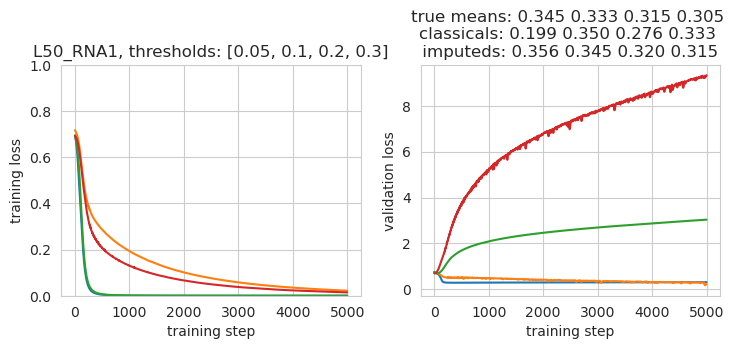

In [6]:
m_to_plot = 4

plt.figure(figsize=(8.5, 3))
plt.subplot(121)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['train_loss']);
plt.xlabel('training step');
plt.ylabel('training loss'); 
plt.title('{}, thresholds: {}'.format(landscape_name, thresholds));
plt.ylim([0, 1]);

plt.subplot(122)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['val_loss']);
plt.xlabel('training step');
plt.ylabel('validation loss');
fstr = ''.join(m * ['{:.3f} '])
format_str = 'true means: {}\nclassicals: {}\n imputeds: {}'.format(fstr, fstr, fstr)
values = np.hstack([truemean_all, classical_all, imputed_all])
plt.title(format_str.format(*values));
# plt.ylim([0, 2]);

In [7]:
reload(vshifts)
reload(tdre)
reload(utils)

seq_len = 50
ns = [100]
n_seed = 5
thresholds = [0.05, 0.1, 0.2, 0.3]
explorer_kwarg_name2vals = {'threshold': thresholds}
data_dir = '/data/wongfanc/dre-data/data/110923'
save_dir = '/data/wongfanc/dre-data/outputs/111023'
n_hidden = 12
config = {
    'waymark_type': 'mixed_dimensions',  # dummy value
    'val_frac': 0.1,
    'n_steps': 2000,
    'lr': 1e-3,
}

landscape_names = flexs.landscapes.rna.registry().keys()
landscape_names = [name for name in landscape_names if 'L{}'.format(seq_len) in name and '+' not in name]
device = torch.device('cuda')
dtype = torch.float

format_str = ''.join(len(thresholds) * ['{:.2f}  '])
for landscape_name in landscape_names:
        for n in ns:
            for seed_idx in range(1, n_seed + 1):
                
                t0 = time()
                X_m1xnxd, y_m1xn, pred_mxn, Xcal_mxnxd, ycal_mxn, predcal_mxn = vshifts.load_rna_data(
                    landscape_name,
                    seed_idx,
                    n,
                    explorer_kwarg_name2vals,
                    data_dir
                )
                model = tdre.UnsharedTelescopingLogDensityRatioEstimator(
                    lambda x: tdre.FeedForward(x, n_hidden=n_hidden),
                    seq_len * 4,
                    n_ratio=len(thresholds),
                    device=device,
                    dtype=dtype
                )

                train_dfs = model.fit(config, X_m1xnxd=X_m1xnxd) 
                truemean_m1 = np.array([np.mean(y_n) for y_n in y_m1xn])
                classical_m = model.forecast_meany_per_bridge(Xcal_mxnxd[-1], ycal_mxn[-1])
                imputed_m = np.array([np.mean(pred_n) for pred_n in pred_mxn])
                
                # report metrics
                classical_rmse = utils.rmse(truemean_m1[: -1], classical_m)
                imputed_rmse = utils.rmse(truemean_m1[: -1], imputed_m)
                print('{}, n = {}, seed {} ({} s).'.format(
                    landscape_name, n, seed_idx, int(time() - t0)
                ))
                print('Train mean: {:.3f}. Design mean: {:.3f}. Classical RMSE: {:.3f}. Imputed RMSE: {:.3f}.'.format(
                    truemean_m1[-1], truemean_m1[0], classical_rmse, imputed_rmse
                ))
                minvalloss_m = [np.min(train_dfs[k]['val_loss']) for k in range(len(thresholds))]
                lastvalloss_m = [train_dfs[k]['val_loss'].iloc[-1] for k in range(len(thresholds))]
                print('Min validation loss per bridge: {}'.format(format_str).format(*minvalloss_m))
                print('Final validation loss per bridge: {}'.format(format_str).format(*lastvalloss_m))
                print()
                
                # save training losses and forecasts
                npz_fname = os.path.join(save_dir, '{}-n{}-seed{}-h{}-forecasts.npz'.format(
                    landscape_name, n, seed_idx, n_hidden
                ))
                np.savez(npz_fname, truemean_m1=truemean_m1, classical_m=classical_m, imputed_m=imputed_m)
                
                assert(len(thresholds) == len(train_dfs))
                for k in range(len(thresholds)):
                    csv_fname = os.path.join(save_dir, '{}-n{}-seed{}-h{}-k{}-training.csv'.format(
                        landscape_name, n, seed_idx, n_hidden, k
                    ))
                    train_dfs[k].to_csv(csv_fname)

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05, 0.1, 0.2, 0.3]
4 waymarks provided


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 357.06it/s]


Done fitting bridge 1 / 4 (5 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 360.37it/s]


Done fitting bridge 2 / 4 (11 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 366.80it/s]


Done fitting bridge 3 / 4 (16 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 373.92it/s]


Done fitting bridge 4 / 4 (21 s).
L50_RNA1, n = 100, seed 1 (22 s).
Train mean: 0.581. Design mean: 0.618. Classical RMSE: 0.068. Imputed RMSE: 0.010.
Min validation loss per bridge: 0.69  0.68  0.69  0.66  
Final validation loss per bridge: 3.82  5.13  7.44  6.78  

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05, 0.1, 0.2, 0.3]
4 waymarks provided


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 382.15it/s]


Done fitting bridge 1 / 4 (5 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 374.36it/s]


Done fitting bridge 2 / 4 (10 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 374.20it/s]


Done fitting bridge 3 / 4 (15 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 377.91it/s]


Done fitting bridge 4 / 4 (21 s).
L50_RNA1, n = 100, seed 2 (21 s).
Train mean: 0.810. Design mean: 0.854. Classical RMSE: 0.072. Imputed RMSE: 0.006.
Min validation loss per bridge: 0.67  0.69  0.70  0.66  
Final validation loss per bridge: 8.33  5.33  6.69  9.49  

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05, 0.1, 0.2, 0.3]
4 waymarks provided


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 385.10it/s]


Done fitting bridge 1 / 4 (5 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 374.95it/s]


Done fitting bridge 2 / 4 (10 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 374.06it/s]


Done fitting bridge 3 / 4 (15 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 375.32it/s]


Done fitting bridge 4 / 4 (21 s).
L50_RNA1, n = 100, seed 3 (21 s).
Train mean: 0.297. Design mean: 0.376. Classical RMSE: 0.070. Imputed RMSE: 0.015.
Min validation loss per bridge: 0.43  0.17  0.39  0.54  
Final validation loss per bridge: 2.28  0.50  1.38  2.79  

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05, 0.1, 0.2, 0.3]
4 waymarks provided


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 373.37it/s]


Done fitting bridge 1 / 4 (5 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 373.83it/s]


Done fitting bridge 2 / 4 (10 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 374.22it/s]


Done fitting bridge 3 / 4 (16 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 373.28it/s]


Done fitting bridge 4 / 4 (21 s).
L50_RNA1, n = 100, seed 4 (21 s).
Train mean: 0.286. Design mean: 0.379. Classical RMSE: 0.039. Imputed RMSE: 0.039.
Min validation loss per bridge: 0.05  0.30  0.22  0.49  
Final validation loss per bridge: 0.08  0.74  0.52  2.12  

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05, 0.1, 0.2, 0.3]
4 waymarks provided


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 358.50it/s]


Done fitting bridge 1 / 4 (5 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 364.40it/s]


Done fitting bridge 2 / 4 (11 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 359.39it/s]


Done fitting bridge 3 / 4 (16 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 365.34it/s]


Done fitting bridge 4 / 4 (22 s).
L50_RNA1, n = 100, seed 5 (22 s).
Train mean: 0.194. Design mean: 0.298. Classical RMSE: 0.070. Imputed RMSE: 0.048.
Min validation loss per bridge: 0.29  0.01  0.13  0.00  
Final validation loss per bridge: 0.61  0.01  0.25  0.00  

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05, 0.1, 0.2, 0.3]
4 waymarks provided


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 433.68it/s]


Done fitting bridge 1 / 4 (4 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 359.21it/s]


Done fitting bridge 2 / 4 (10 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 359.06it/s]


Done fitting bridge 3 / 4 (15 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 358.96it/s]


Done fitting bridge 4 / 4 (21 s).
L50_RNA2, n = 100, seed 1 (21 s).
Train mean: 0.548. Design mean: 0.621. Classical RMSE: 0.059. Imputed RMSE: 0.005.
Min validation loss per bridge: 0.01  0.35  0.70  0.62  
Final validation loss per bridge: 0.01  1.25  5.76  10.03  

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05, 0.1, 0.2, 0.3]
4 waymarks provided


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 369.71it/s]


Done fitting bridge 1 / 4 (5 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 359.57it/s]


Done fitting bridge 2 / 4 (10 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 359.84it/s]


Done fitting bridge 3 / 4 (16 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 389.16it/s]


Done fitting bridge 4 / 4 (21 s).
L50_RNA2, n = 100, seed 2 (21 s).
Train mean: 0.871. Design mean: 0.929. Classical RMSE: 0.066. Imputed RMSE: 0.006.
Min validation loss per bridge: 0.68  0.69  0.60  0.72  
Final validation loss per bridge: 4.35  12.08  2.66  7.28  

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05, 0.1, 0.2, 0.3]
4 waymarks provided


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 359.61it/s]


Done fitting bridge 1 / 4 (5 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 359.81it/s]


Done fitting bridge 2 / 4 (11 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 359.86it/s]


Done fitting bridge 3 / 4 (16 s).


100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 360.39it/s]


Done fitting bridge 4 / 4 (22 s).
L50_RNA2, n = 100, seed 3 (22 s).
Train mean: 0.258. Design mean: 0.291. Classical RMSE: 0.013. Imputed RMSE: 258920219.632.
Min validation loss per bridge: 0.07  0.09  0.13  0.54  
Final validation loss per bridge: 0.20  0.09  0.23  1.95  

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05, 0.1, 0.2, 0.3]
4 waymarks provided


 71%|██████████████████████████████████████████████████████████▍                       | 1424/2000 [00:03<00:01, 359.13it/s]

KeyboardInterrupt



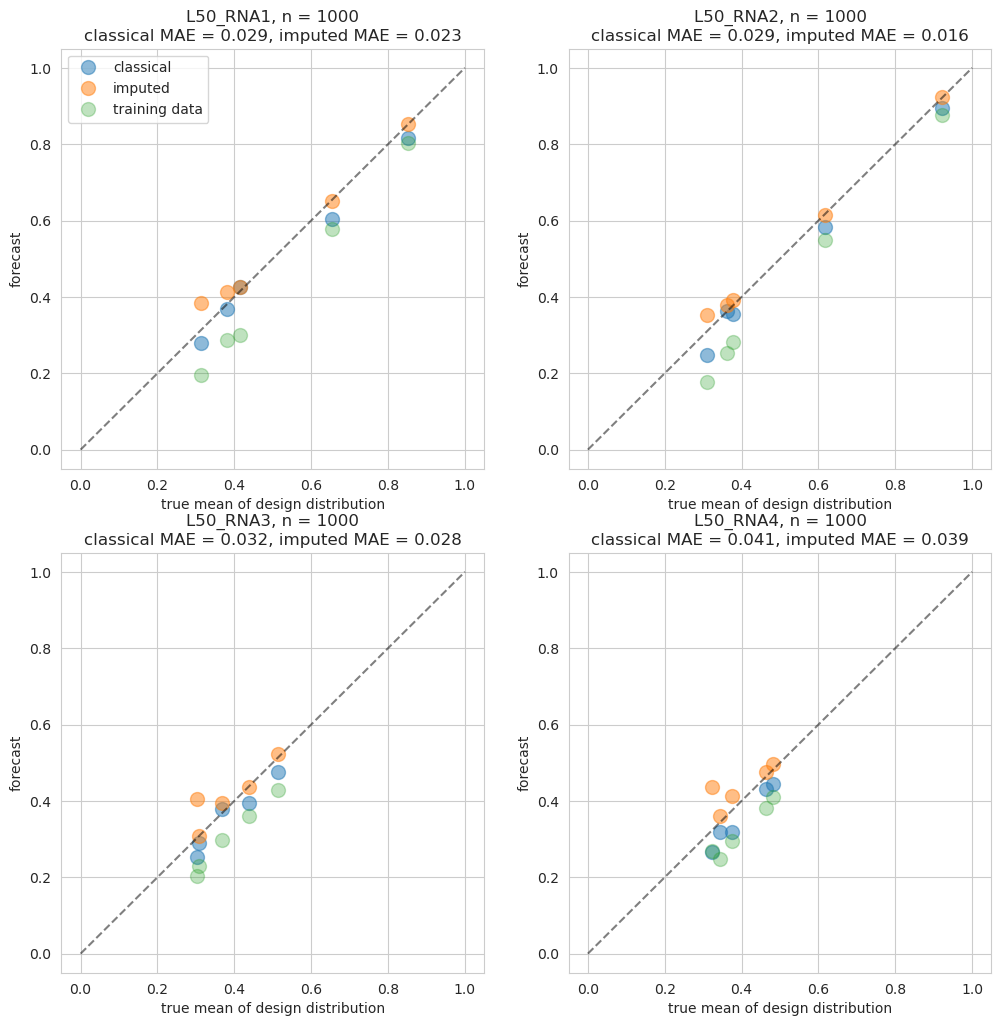

In [13]:
n = 1000
n_hidden = 16
seed_idxs = range(1, n_seed + 1)
plt.figure(figsize=(12, 12))

for l, landscape_name in enumerate(landscape_names):
    plt.subplot(2, 2, l + 1)
    
    true_sx2 = np.zeros([n_seed, 2])
    classical_s = np.zeros([n_seed])
    imputed_s = np.zeros([n_seed])
    
    for seed_idx in seed_idxs:
        npz_fname = os.path.join(save_dir, '{}-n{}-seed{}-h{}-forecasts.npz'.format(
            landscape_name, n, seed_idx, n_hidden
        ))
        dload = np.load(npz_fname)
        truemean_m1 = dload['truemean_m1']
        classical_m = dload['classical_m']
        imputed_m = dload['imputed_m']
        
        true_sx2[seed_idx - 1] = truemean_m1[0], truemean_m1[-1]
        classical_s[seed_idx - 1] = classical_m[0]
        imputed_s[seed_idx - 1] = imputed_m[0]
    classical_mae = np.mean(np.abs(true_sx2[:, 0] - classical_s))
    imputed_mae = np.mean(np.abs(true_sx2[:, 0] - imputed_s))
        
    plt.plot(true_sx2[:, 0], classical_s, 'o', alpha=0.5, markersize=10, label='classical')
    plt.plot(true_sx2[:, 0], imputed_s, 'o', alpha=0.5, markersize=10, label='imputed')
    plt.plot(true_sx2[:, 0], true_sx2[:, 1], 'o', alpha=0.3, markersize=10, label='training data')
    plt.plot([0, 1], [0, 1], '--k', alpha=0.5)
    plt.title('{}, n = {}\nclassical MAE = {:.3f}, imputed MAE = {:.3f}'.format(
        landscape_name, n, classical_mae, imputed_mae
    ))
    plt.xlabel('true mean of design distribution');
    plt.ylabel('forecast');
    
plt.subplot(2, 2, 1)
plt.legend();

In [10]:
# just seeing how naive quantiles look, for n = 100

reload(vshifts)
reload(tdre)
reload(utils)

seq_len = 50
ns = [100]
n_seed = 5
qs = np.arange(0.1, 1, 0.1)
data_dir = '/data/wongfanc/dre-data/data/110923'

landscape_names = flexs.landscapes.rna.registry().keys()
landscape_names = [name for name in landscape_names if 'L{}'.format(seq_len) in name and '+' not in name]

format_str = ''.join(qs.size * ['{:.2f}  '])
for landscape_name in landscape_names:
        for n in ns:
            for seed_idx in range(1, n_seed + 1):
                
                X_m1xnxd, y_m1xn, pred_mxn, Xcal_mxnxd, ycal_mxn, predcal_mxn = vshifts.load_rna_data(
                    landscape_name,
                    seed_idx,
                    n,
                    explorer_kwarg_name2vals,
                    data_dir
                )
                
                print('{}, n = {}, seed {}.'.format(landscape_name, n, seed_idx))
                
                true_q = [np.quantile(y_m1xn[0], q=q) for q in qs]
                train_q = [np.quantile(y_m1xn[-1], q=q) for q in qs]
                imputed_q = [np.quantile(pred_mxn[0], q=q) for q in qs]
                print('   Design: {}'.format(format_str).format(*true_q))
                print('    Train: {}'.format(format_str).format(*train_q))
                print('  Imputed: {}'.format(format_str).format(*imputed_q))

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05, 0.1, 0.2, 0.3]
L50_RNA1, n = 100, seed 1.
   Design: 0.59  0.60  0.61  0.61  0.62  0.62  0.63  0.64  0.64  
    Train: 0.53  0.55  0.56  0.57  0.59  0.60  0.61  0.62  0.64  
  Imputed: 0.60  0.61  0.62  0.62  0.63  0.64  0.64  0.64  0.65  
Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05, 0.1, 0.2, 0.3]
L50_RNA1, n = 100, seed 2.
   Design: 0.83  0.84  0.84  0.85  0.85  0.86  0.86  0.87  0.88  
    Train: 0.74  0.76  0.78  0.80  0.81  0.82  0.85  0.87  0.90  
  Imputed: 0.84  0.84  0.85  0.85  0.86  0.86  0.87  0.88  0.88  
Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05, 0.1, 0.2, 0.3]
L50_RNA1, n = 100, seed 3.
   Design: 0.34  0.36  0.37  0.37  0.38 

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05, 0.1, 0.2, 0.3]
Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05, 0.1, 0.2, 0.3]
Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05, 0.1, 0.2, 0.3]
Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05, 0.1, 0.2, 0.3]
Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05, 0.1, 0.2, 0.3]
Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05, 0.1, 0.2, 0.3]
Problem has sequence length 50
Loa

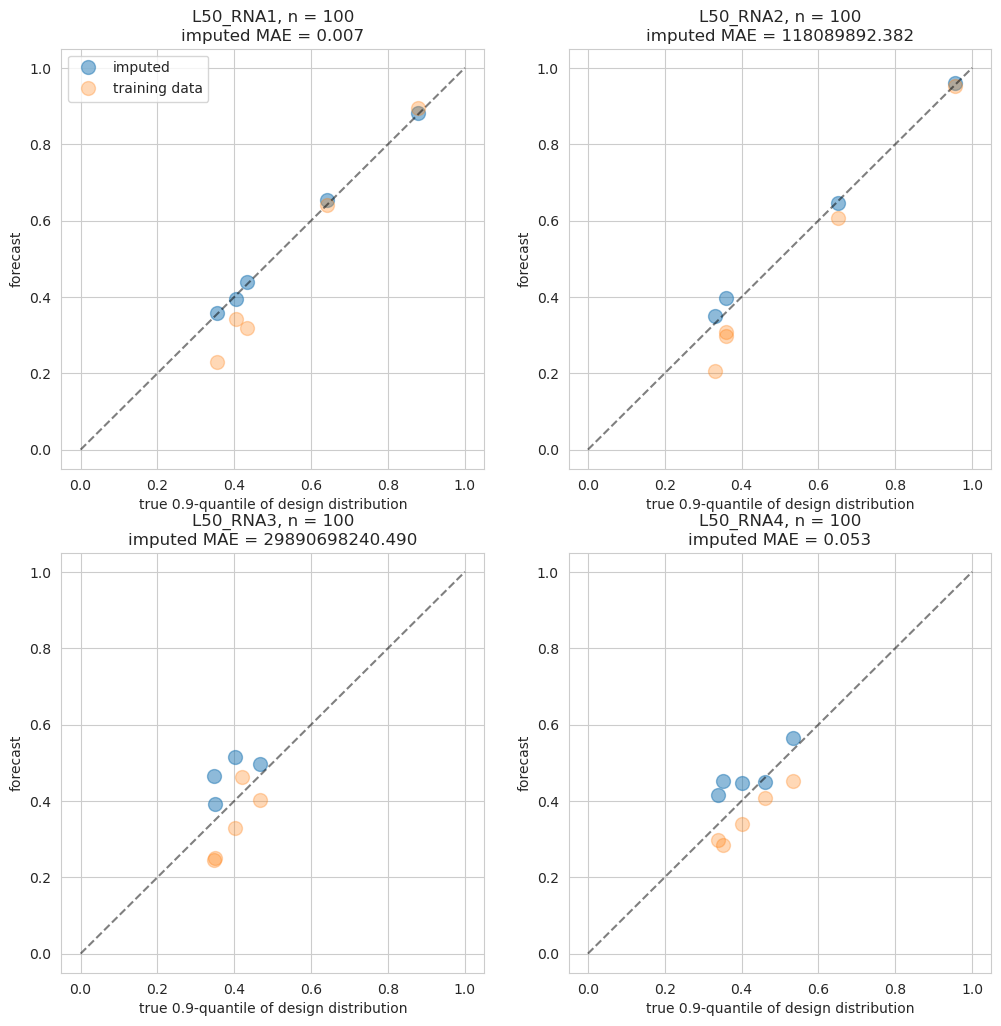

In [19]:
n = 100
q = 0.9
seed_idxs = range(1, n_seed + 1)
plt.figure(figsize=(12, 12))

for l, landscape_name in enumerate(landscape_names):
    plt.subplot(2, 2, l + 1)
    
    true_sx2 = np.zeros([n_seed, 2])
    imputed_s = np.zeros([n_seed])
    
    for seed_idx in seed_idxs:
        
        X_m1xnxd, y_m1xn, pred_mxn, Xcal_mxnxd, ycal_mxn, predcal_mxn = vshifts.load_rna_data(
            landscape_name,
            seed_idx,
            n,
            explorer_kwarg_name2vals,
            data_dir
        )
        
        true_sx2[seed_idx - 1] = np.quantile(y_m1xn[0], q=q), np.quantile(y_m1xn[-1], q=q)
        imputed_s[seed_idx - 1] = np.quantile(pred_mxn[0], q=q)
    imputed_mae = np.mean(np.abs(true_sx2[:, 0] - imputed_s))
        
    plt.plot(true_sx2[:, 0], imputed_s, 'o', alpha=0.5, markersize=10, label='imputed')
    plt.plot(true_sx2[:, 0], true_sx2[:, 1], 'o', alpha=0.3, markersize=10, label='training data')
    plt.plot([0, 1], [0, 1], '--k', alpha=0.5)
    plt.title('{}, n = {}\nimputed MAE = {:.3f}'.format(
        landscape_name, n, imputed_mae
    ))
    plt.xlabel('true {}-quantile of design distribution'.format(q));
    plt.ylabel('forecast');
    plt.xlim([-0.05, 1.05]);
    plt.ylim([-0.05, 1.05])
    
plt.subplot(2, 2, 1)
plt.legend();

# find setting where imputed quantiles are inaccurate

In [65]:
reload(vshifts)
n = 1000
seed_idx = 4
avg_n_mut = 3
noise_sd = 0.01
seq_len = 50 

model_class = flexs.baselines.models.RidgeCV
model_kwargs = {
    'alphas': [1e-2, 1e-1, 1, 10, 100],
    'cv': 5
}

explorer_class = flexs.baselines.explorers.Adalead
explorer_kwarg_name2vals = {'threshold': [0.05]}

flexsshift = vshifts.FLEXSShift(landscape_name, noise_sd=noise_sd)
trainseqs_n, ytrain_n, calseqs_n, ycal_n, predcal_n, testseqs_list, yseed = flexsshift.get_data(
    n,
    model_class,
    explorer_class,
    explorer_kwarg_name2vals,
    model_kwargs=model_kwargs,
    seed_idx=seed_idx,
    avg_n_mut=avg_n_mut,
    save_fname_prefix=None
)    

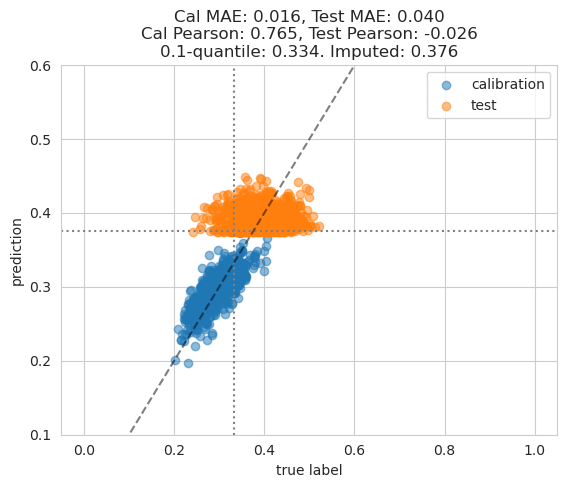

In [70]:
q = 0.1

testseqs_n, ytest_n, predtest_n = testseqs_list[0]
mae_cal = np.mean(np.abs(ycal_n - predcal_n))
mae_test = np.mean(np.abs(ytest_n - predtest_n))
r_cal, _ = sc.stats.pearsonr(ycal_n, predcal_n)
r_test, _ = sc.stats.pearsonr(ytest_n, predtest_n)

q_real = np.quantile(ytest_n, q)
q_imputed = np.quantile(predtest_n, q)

plt.scatter(ycal_n, predcal_n, alpha=0.5, label='calibration');
plt.scatter(ytest_n, predtest_n, alpha=0.5, label='test');
plt.axvline(q_real, linestyle=':', color='gray')
plt.axhline(q_imputed, linestyle=':', color='gray')
plt.title('Cal MAE: {:.3f}, Test MAE: {:.3f}\nCal Pearson: {:.3f}, Test Pearson: {:.3f}\n{}-quantile: {:.3}. Imputed: {:.3f}'.format(
    mae_cal, mae_test, r_cal, r_test, q, q_real, q_imputed));
plt.plot([0, 1], [0, 1], '--k', alpha=0.5);
plt.ylim([0.1, 0.6]);
plt.xlabel('true label');
plt.ylabel('prediction');
plt.legend();

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05]
Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05]
Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05]
Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05]
Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.05]


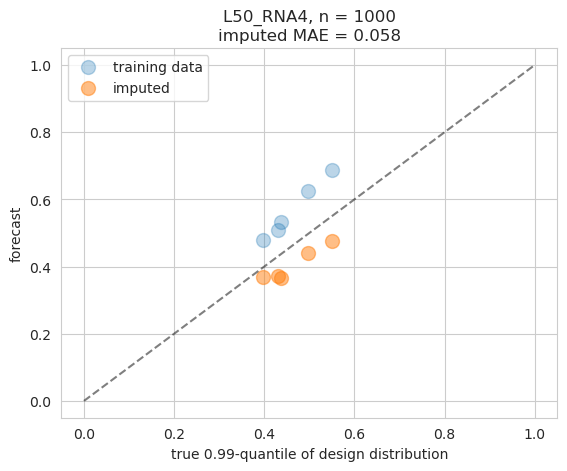

In [29]:
# cnn
reload(vshifts)
n = 1000
q = 0.99
n_seed = 5
seed_idxs = range(1, n_seed + 1)
landscape_name = 'L50_RNA4'
explorer_kwarg_name2vals = {'threshold': [0.05]}
data_dir = '/data/wongfanc/dre-data/data/111423'

    
true_sx2 = np.zeros([n_seed, 2])
imputed_s = np.zeros([n_seed])

for seed_idx in seed_idxs:

    X_m1xnxd, y_m1xn, pred_mxn, Xcal_mxnxd, ycal_mxn, predcal_mxn = vshifts.load_rna_data(
        landscape_name,
        seed_idx,
        n,
        explorer_kwarg_name2vals,
        data_dir
    )

    true_sx2[seed_idx - 1] = np.quantile(y_m1xn[0], q=q), np.quantile(y_m1xn[-1], q=q)
    imputed_s[seed_idx - 1] = np.quantile(pred_mxn[0], q=q)
imputed_mae = np.mean(np.abs(true_sx2[:, 0] - imputed_s))

plt.plot(true_sx2[:, 0], true_sx2[:, 1], 'o', alpha=0.3, markersize=10, label='training data')
plt.plot(true_sx2[:, 0], imputed_s, 'o', alpha=0.5, markersize=10, label='imputed')
plt.plot([0, 1], [0, 1], '--k', alpha=0.5)
plt.title('{}, n = {}\nimputed MAE = {:.3f}'.format(
    landscape_name, n, imputed_mae
))
plt.xlabel('true {}-quantile of design distribution'.format(q));
plt.ylabel('forecast');
plt.xlim([-0.05, 1.05]);
plt.ylim([-0.05, 1.05])
    
plt.legend();

# 11.21.23 generating multiple trials of RNA data

In [ ]:
# generate multiple trials
model_class = flexs.baselines.models.LinearRegression
model_kwargs = {}

explorer_class = flexs.baselines.explorers.Adalead
thresholds = [0.3, 0.2, 0.1, 0.05, 0.01]
explorer_kwarg_name2vals = {'threshold': thresholds}

save_fname_dir = '112123'

noise_sd = 0.02
n_trial = 10
seed_idx = 4
landscape_name = 'L50_RNA1'
ns = [5000, 4000, 3000]
avg_n_muts = [4, 5, 3]

vshifts.generate_rna_data(
    model_class,
    explorer_class,
    explorer_kwarg_name2vals,
    save_fname_dir,
    noise_sd=noise_sd,
    n_trial=n_trial,
    model_kwargs=model_kwargs,
    seq_len=50,
    seed_idxs=[seed_idx],
    landscape_names=[landscape_name],
    ns=ns,
    avg_n_muts=avg_n_muts
)

Generating data from the following landscapes:
['L50_RNA1']
with the following amounts of training data:
[5000, 4000, 3000]
Saved training, calibration, and design data to /data/wongfanc/dre-data/data/112123/L50_RNA1/trial0/seed4-n5000-nmut4-threshold0.3.npz
Saved training, calibration, and design data to /data/wongfanc/dre-data/data/112123/L50_RNA1/trial0/seed4-n5000-nmut4-threshold0.2.npz
Saved training, calibration, and design data to /data/wongfanc/dre-data/data/112123/L50_RNA1/trial0/seed4-n5000-nmut4-threshold0.1.npz
Saved training, calibration, and design data to /data/wongfanc/dre-data/data/112123/L50_RNA1/trial0/seed4-n5000-nmut4-threshold0.05.npz
Saved training, calibration, and design data to /data/wongfanc/dre-data/data/112123/L50_RNA1/trial0/seed4-n5000-nmut4-threshold0.01.npz
Generated and saved data for L50_RNA1, n = 5000, seed 4, avg. # train mutations 4 (297 s).
Saved training, calibration, and design data to /data/wongfanc/dre-data/data/112123/L50_RNA1/trial1/seed4-n5